# Section 5.4 Lab: Cross-Validation and the Bootstrap

## The Validation Set Approach

<img src="./images/validation.png">

We explore the use of validation set approach in order to estimate the test error rates that result from fitting various linear models on the **Auto** dataset.

In [1]:
library(ISLR)
library(magrittr)
set.seed(1)
attach(Auto)

We begin using the `sample()` function to split the set of obs into two halves, by selecting a random subset of 196 obs out of the original 392 obs. We refer to these obs as the trainig set.

In [2]:
train = sample(392, 196)

In [3]:
lm.fit = lm(mpg ~ horsepower, data = Auto, subset = train)

Now we calculate the **MSE** of all the 196 obs in the validation set.

In [4]:
mean((mpg - predict(lm.fit, Auto))[-train]^2) 

[1] 23.26601

Similarly we can fit a quatric and cubic regressions

In [5]:
lm.fit2 = lm(mpg ~ poly(horsepower, 2), data = Auto, subset = train)
mean((mpg - predict(lm.fit2, Auto))[-train]^2) 

[1] 18.71646

In [6]:
lm.fit3 = lm(mpg ~ poly(horsepower, 3), data = Auto, subset = train)
mean((mpg - predict(lm.fit3, Auto))[-train]^2) 

[1] 18.79401

If we choose a different trainig set instead we will obtain different errors on the validation set

In [7]:
set.seed(2)
train = sample(392, 196)

# LINEAR
lm.fit = lm(mpg ~ horsepower, data = Auto, subset = train)
mean((mpg - predict(lm.fit, Auto))[-train]^2) 

# CUADRATIC
lm.fit2 = lm(mpg ~ poly(horsepower, 2), data = Auto, subset = train)
mean((mpg - predict(lm.fit2, Auto))[-train]^2)

#CUBIC
lm.fit3 = lm(mpg ~ poly(horsepower, 3), data = Auto, subset = train)
mean((mpg - predict(lm.fit3, Auto))[-train]^2) 

[1] 25.72651

[1] 20.43036

[1] 20.38533

## Leave One-Out Cross-Validation

<img src="./images/loocv.png">

*LOOCV* can be computed automatically for any generalized linear model usin the `glm()` and `cv.glm()` functions. If we use `glm()` to fit a model without passing in the `family` argument, then it performs a linear regresssion, just like `lm()` function. 

In [8]:
glm.fit = glm(mpg ~ horsepower, data = Auto)
coef(glm.fit)

(Intercept)  horsepower 
 39.9358610  -0.1578447

In [9]:
library(boot)

In [10]:
cv.err = cv.glm(Auto, glm.fit) # K gives a LOOCV if not specified
cv.err$delta

[1] 24.23151 24.23114

`cv.glm()` function produces a list with several components. The two numbers in the `delta` vector contain the cross-validation results corresponding to this formulae:


$$CV_{(n)} = \frac{1}{n}\sum_{i=1}^{n}{MSE_{i}}$$

We can repeat this procedure for increasing complex polynomial fits, using a `for()` loop.

In [26]:
cv.error = rep(0,5)
for (i in 1:5){
    glm.fit = glm(mpg ~ poly(horsepower, i), data = Auto)
    cv.error[i] = cv.glm(Auto, glm.fit)$delta[1]
}
round(cv.error, 3)

[1] 24.232 19.248 19.335 19.424 19.033

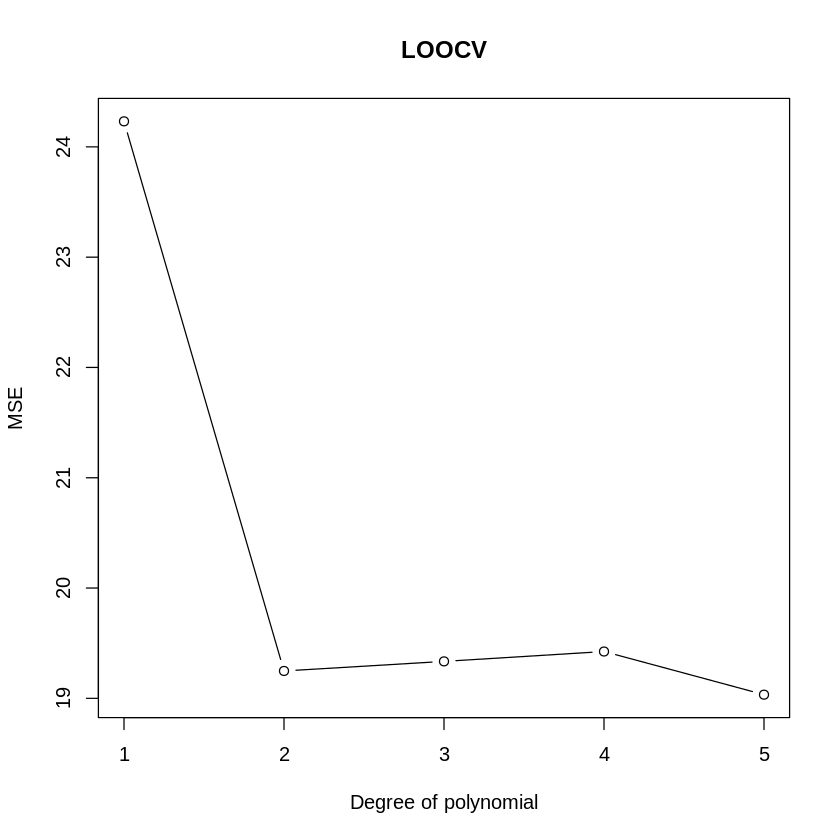

In [27]:
plot(cv.error, type = "b", xlab = "Degree of polynomial", ylab = "MSE", main = "LOOCV")

We observe a sharp drop in the estimated test MSE between the linear and quadratic fits, but then no clear improvement from using higher-order polynomials.

## k-Fold Cross-Validation

<img src="./images/kfoldcv.png">

We only need to use $K = 10$ on the `cv.glm()` function and adjust the code to iterate 10 times.

In [22]:
set.seed(17)
cv.error.10 = rep(0,10)
for (i in 1:10){
    glm.fit = glm(mpg ~ poly(horsepower, i), data = Auto)
    cv.error.10[i] = cv.glm(Auto, K = 10, glm.fit)$delta[1]
}
round(cv.error.10, 3)

[1] 24.272 19.269 19.348 19.295 19.032 18.898 19.121 19.147 18.870 20.955

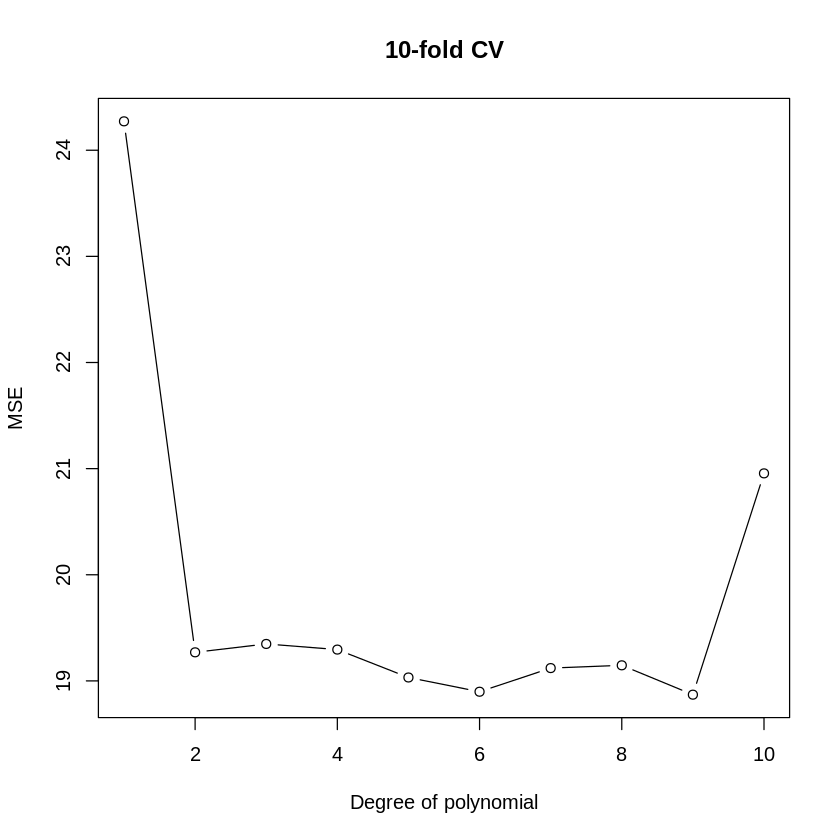

In [28]:
plot(cv.error.10, type = "b", xlab = "Degree of polynomial", ylab = "MSE", main = "10-fold CV")

Notice that the computation is much shorter than that of LOOCV. 

## The Bootstrap

<img src="./images/bootstrap.png">

 ### Estimating the Accuracy of a Statistic o Interest

Performing bootstrap analysis in R entails two steps:
* create a function that creates the statistic of interes
* use the `boot()` function to perfomr the bootstrap by repeatedly sampling obs from the data with replacement.

Following the example from the Boostrap section, we will use the `portfolio` dataset. First we need to compute the `alpha.fn()` function, which takes the $(X,Y)$ data as well as a vector indication which obs should be used in order to estimate $\alpha$ 

In [13]:
alpha <- function(data, index){
        X = data$X[index]
        Y = data$Y[index]
    return((var(Y) - cov(X,Y))/(var(X) + var(Y) - 2*cov(X,Y)))
}

In [14]:
alpha(Portfolio, 1:100)

[1] 0.5758321

The next command uses the `sample()` function to randomly select 100 obs from the range 1:100, with replacement. This is equivalent to constructing a new bootstrap data set and recomputing $\hat\alpha$ based on  the new data set.

In [15]:
set.seed(1)
(my.sample <- sample(100, # x, a vector or positive integer
                     100, # size
                     replace = T))

[1]  68  39   1  34  87  43  14  82  59  51  97  85  21  54  74   7  73  79
 [19]  85  37  89  37  34  89  44  79  33  84  35  70  74  42  38  20  28  20
 [37]  44  87  70  40  44  25  70  39  51  42   6  24  32  14   2  45  18  22
 [55]  78  65  70  87  70  75  81 100  13  40  89  48  89  23  84  29  13  22
 [73]  93  28  48  33  45  21  31  17  73  87  83  90  48  64  94  96  60  51
 [91]  93  34  10   1  43  59  26  15  58  29

In [16]:
alpha(Portfolio, my.sample) %>% round(3)

[1] 0.737

We can implement a bootstrap analysis by permforming this code many times, recording all the corresponding estimates for $\alpha$, and computing the resulting standard deviation. However the `boot()` funciton automates this approach. Below we produce R = 1000 bootstrap estimates for $\alpha$

In [18]:
boot(Portfolio,
     alpha,
     R = 1000) # Number of bootstrap samples


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Portfolio, statistic = alpha, R = 1000)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.5758321 -0.001539618  0.08846251

### Estimating the Accuracy of a Linear Regression Model

The bootstrap approach can be used to assess the variability of the coefficient estimates and prediction from a stadistical learning method. Here we use the bootstrap to asses the variability for $\beta_0$ and $\beta_1$, the intercept and slope terms for a linear regression model.

We will compare the estimates using the bootstrap to those obtained using the formulas for $SE(\hat\beta_0)$ and $SE(\hat\beta_1)$.

In [33]:
boot.fn = function(data, index) {
    return(coef(lm(mpg ~ horsepower, data = data, subset = index)))
}

boot.fn(Auto, 1:392) %>% round(3)

(Intercept)  horsepower 
     39.936      -0.158

Also we can use randomnly sampling with replacement:

In [35]:
set.seed(1)

boot.fn(Auto, sample(392,392, replace = T)) %>% round(3)

(Intercept)  horsepower 
     40.340      -0.163

Next, we use the `boot()` function to compute the standard erros of 1000 bootstrap estimates for the intercept and slope terms

In [53]:
boot(Auto, boot.fn, 1000)


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Auto, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
      original        bias    std. error
t1* 39.9358610  5.119817e-04 0.857404169
t2* -0.1578447 -9.095879e-05 0.007444869

* $SE(\hat\beta_0)$ = 0.857
* $SE(\hat\beta_1)$ = 0.007

Standard formulas

$$SE(\hat\beta_0)^2 = \sigma^2 \left[ \frac{1}{n} + \frac{{\overline{x}}^2}{\sum_{i = 1}^n{(x_i - \overline{x})^2}} \right] $$

$$SE(\hat\beta_1)^2 = \frac{\sigma^2}{\sum_{i = 1}^n{(x_i - \overline{x})^2}}$$

can be used to compute the standard erros for the regression coefficients in a linear model. These can be obtained using the `summary()` function. 

In [59]:
summary(lm(mpg ~ horsepower, data = Auto))$coef

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),39.9358610,0.717498656,55.65984,1.220362e-187
horsepower,-0.1578447,0.006445501,-24.48914,7.031989e-81


* $SE(\hat\beta_0)$ = 0.717
* $SE(\hat\beta_1)$ = 0.006

Interestingly, these coefficients are somewhat differents from the obtained using bootstrap. Does it indicate a problem with the bootstrap? In fact, it suggests just the opposite. Recall that the above standard formulas rely on certain assumptions. For example, they depend on the unknown parameter $\sigma^2$ the noise variance. We then estimates $\sigma^2$ using the RSS. Now although the formula for the standard erros do not rely on the linear model being correct, the estimate of $\sigma^2$  does. In this figure : 

Warning message in plot.window(...):
“"data" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"data" is not a graphical parameter”Warning message in axis(side = side, at = at, labels = labels, ...):
“"data" is not a graphical parameter”Warning message in axis(side = side, at = at, labels = labels, ...):
“"data" is not a graphical parameter”Warning message in box(...):
“"data" is not a graphical parameter”Warning message in title(...):
“"data" is not a graphical parameter”

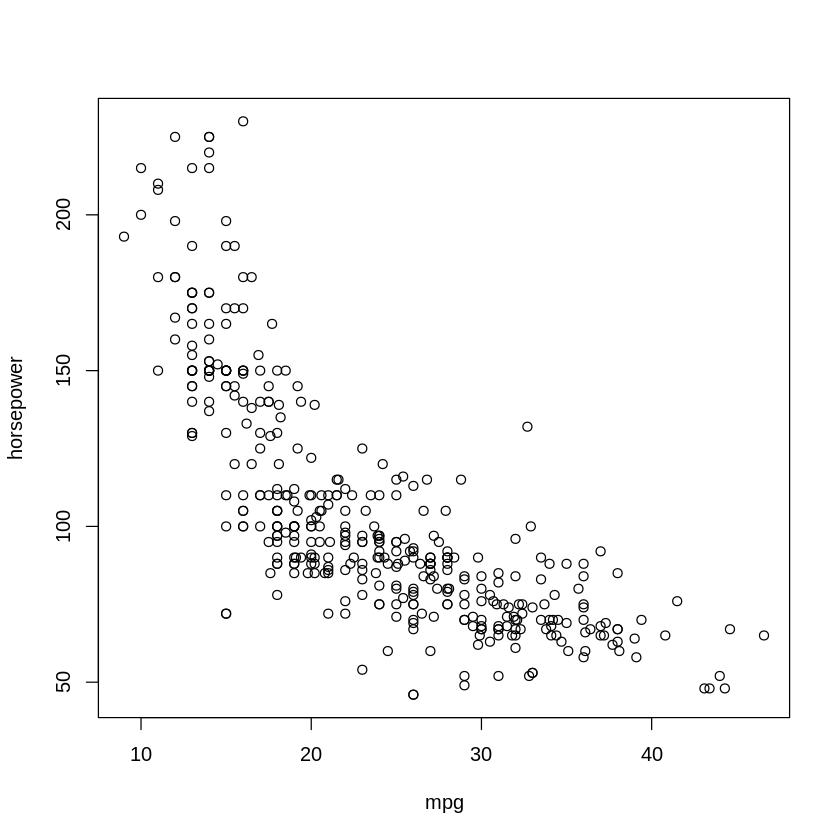

In [63]:
plot(mpg, horsepower, data = Auto)

we can see that there is a non-linear relationship in the data, and so the residuals from a linear fit will be inflated and so will $\hat\sigma^2
$.

Secondly the standard formulas assume (somewhat unrealistic) that the $X_i$ are fixed, and all the variability comes from the variation in the errors $\epsilon_i$. **The bootstrap does not rely on any of these assumptions, and so it is likely givin a more accurate of the standard erros of $\hat\beta_0$ and $\hat\beta_1$ than is the `summary()` function.**

Below we compute the bootstrap standard error estimates and the standard lineal regression estimates that result from fitting the quadratic model to the data. Since this model provides a good fit to the data there is  now a better correspondence between the bootstrap estimates and the standard estimates of $SE(\hat\beta_0)$, $SE(\hat\beta_1)$ and $SE(\hat\beta_2)$


In [67]:
boot.fn = function(data, index){
    return(coef(lm(mpg ~ horsepower + I(horsepower^2), data = data, subset = index)))
}
set.seed(1)
boot(Auto, boot.fn, 1000)

summary(lm(mpg ~ horsepower + I(horsepower^2), data = Auto))$coef


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Auto, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
        original        bias     std. error
t1* 56.900099702  3.511640e-02 2.0300222526
t2* -0.466189630 -7.080834e-04 0.0324241984
t3*  0.001230536  2.840324e-06 0.0001172164

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),56.900099702,1.8004268063,31.60367,1.740911e-109
horsepower,-0.466189630,0.0311246171,-14.97816,2.289429e-40
I(horsepower^2),0.001230536,0.0001220759,10.08009,2.196340e-21
